In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report as cr
from sklearn.metrics import accuracy_score as accu
from sklearn.metrics import roc_curve,auc,precision_recall_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.neural_network import MLPClassifier as mlp

In [2]:
# load master dataset
df = pd.read_csv("h1b_dataset.csv", encoding = "ISO-8859-1")
df.head()

C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CASE_SUBMITTED_DAY,CASE_SUBMITTED_MONTH,CASE_SUBMITTED_YEAR,DECISION_DAY,DECISION_MONTH,DECISION_YEAR,VISA_CLASS,EMPLOYER_NAME,EMPLOYER_STATE,EMPLOYER_COUNTRY,...,PW_SOURCE_YEAR,PW_SOURCE_OTHER,WAGE_RATE_OF_PAY_FROM,WAGE_RATE_OF_PAY_TO,WAGE_UNIT_OF_PAY,H-1B_DEPENDENT,WILLFUL_VIOLATOR,WORKSITE_STATE,WORKSITE_POSTAL_CODE,CASE_STATUS
0,24,2,2016,1,10,2016,H1B,DISCOVER PRODUCTS INC,IL,UNITED STATES OF AMERICA,...,2015.0,OFLC ONLINE DATA CENTER,65811.0,67320.0,Year,N,N,IL,60015,CERTIFIEDWITHDRAWN
1,4,3,2016,1,10,2016,H1B,DFS SERVICES LLC,IL,UNITED STATES OF AMERICA,...,2015.0,WILLIS TOWERS WATSON SURVEY,53000.0,57200.0,Year,N,N,IL,60015,CERTIFIEDWITHDRAWN
2,10,3,2016,1,10,2016,H1B,EASTBANC TECHNOLOGIES LLC,DC,UNITED STATES OF AMERICA,...,2015.0,OFLC ONLINE DATA CENTER,77000.0,0.0,Year,Y,N,DC,20007,CERTIFIEDWITHDRAWN
3,28,9,2016,1,10,2016,H1B,INFO SERVICES LLC,MI,UNITED STATES OF AMERICA,...,2016.0,OFLC ONLINE DATA CENTER,102000.0,0.0,Year,Y,N,NJ,7302,WITHDRAWN
4,22,2,2015,2,10,2016,H1B,BBandT CORPORATION,NC,UNITED STATES OF AMERICA,...,2015.0,OFLC ONLINE DATA CENTER,132500.0,0.0,Year,N,N,NY,10036,CERTIFIEDWITHDRAWN


In [3]:
#extract samples with labels: denined/certified
df_binary = df.loc[df['CASE_STATUS'] == 'DENIED']
df_binary = df_binary.append(df.loc[df['CASE_STATUS'] == 'CERTIFIED'])
df_binary.shape

(475952, 27)

In [4]:
#number of samples with label = 'DENIED'
n_denied = len(df_binary[df_binary.CASE_STATUS == 'DENIED'])
n_certi = len(df_binary[df_binary.CASE_STATUS == 'CERTIFIED'])
n_denied

6983

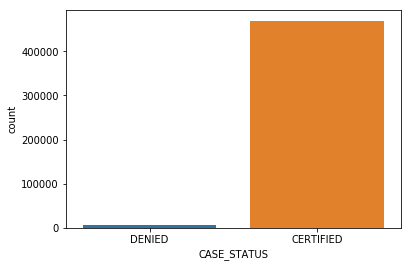

In [5]:
#Plot to observe that data is skewed
sns.countplot(df_binary['CASE_STATUS'])

In [6]:
#Balance dataset for both labels by taking random sample of "CERTIFIED" data label
df_final = pd.DataFrame()
df_final = df_binary.loc[df_binary.CASE_STATUS == 'CERTIFIED'].sample(n_denied, random_state=42)\
            .append(df_binary.loc[df_binary.CASE_STATUS=='DENIED'])

#Checking
print("Number of DENIED samples:",list(df_final['CASE_STATUS']).count('DENIED'))
print("Number of CERTIFIED samples:", list(df_final['CASE_STATUS']).count('CERTIFIED'))
print("Shape of combined dataset:",df_final.shape)

Number of DENIED samples: 6983
Number of CERTIFIED samples: 6983
Shape of combined dataset: (13966, 27)


In [7]:
# There are multiple visa classes in dataset
df_final['VISA_CLASS'].value_counts()

H1B               13060
E3 Australian       791
H1B1 Chile           66
H1B1 Singapore       49
Name: VISA_CLASS, dtype: int64

In [8]:
# Keep samples having visa_class = 'H1B' only
df_final = df_final[df_final.VISA_CLASS == 'H1B']
print(df_final['VISA_CLASS'].value_counts())
df_final.shape

H1B    13060
Name: VISA_CLASS, dtype: int64


(13060, 27)

In [9]:
#Utility function to rescale wages to 'yearly'
def rescale_wage(value, type_):
    
    v = value
    
    if type_ == 'Month':
        v *= 12    
    if type_ == 'Week':
        v *= 52
    if type_ == 'Hour':
        v *= 40 * 52
    if type_ == 'Bi-Weekly':
        v *= 26 
    return v
        

In [10]:
#Rescale wage_rate_of_pay and prevailing_wage to 'yearly'
df_final['PREVAILING_WAGE'] = df_final[['PREVAILING_WAGE', 'PW_UNIT_OF_PAY']]\
                    .apply(lambda x: rescale_wage(x['PREVAILING_WAGE'], x['PW_UNIT_OF_PAY']), axis=1)

df_final['WAGE_RATE_OF_PAY_FROM'] = df_final[['WAGE_RATE_OF_PAY_FROM', 'WAGE_UNIT_OF_PAY']]\
                    .apply(lambda x: rescale_wage(x['WAGE_RATE_OF_PAY_FROM'], x['WAGE_UNIT_OF_PAY']), axis=1)

print(df_final['WAGE_RATE_OF_PAY_FROM'].head())
print(df_final['PREVAILING_WAGE'].head())

184141    115000.0
490923    129323.0
277751     60000.0
107933     95000.0
520727     38043.0
Name: WAGE_RATE_OF_PAY_FROM, dtype: float64
184141    110219.0
490923    129323.0
277751     48838.0
107933     90813.0
520727     38043.0
Name: PREVAILING_WAGE, dtype: float64


In [11]:
#Check for null values and data types
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13060 entries, 184141 to 528112
Data columns (total 27 columns):
CASE_SUBMITTED_DAY       13060 non-null int64
CASE_SUBMITTED_MONTH     13060 non-null int64
CASE_SUBMITTED_YEAR      13060 non-null int64
DECISION_DAY             13060 non-null int64
DECISION_MONTH           13060 non-null int64
DECISION_YEAR            13060 non-null int64
VISA_CLASS               13060 non-null object
EMPLOYER_NAME            13057 non-null object
EMPLOYER_STATE           13060 non-null object
EMPLOYER_COUNTRY         13060 non-null object
SOC_NAME                 13060 non-null object
NAICS_CODE               13058 non-null float64
TOTAL_WORKERS            13060 non-null int64
FULL_TIME_POSITION       13058 non-null object
PREVAILING_WAGE          13060 non-null float64
PW_UNIT_OF_PAY           13039 non-null object
PW_SOURCE                13039 non-null object
PW_SOURCE_YEAR           13040 non-null float64
PW_SOURCE_OTHER          13060 non-null obj

In [12]:
#Remove unnecessary columns
df_final = df_final.drop(columns=['EMPLOYER_COUNTRY', 'CASE_SUBMITTED_DAY', 'CASE_SUBMITTED_MONTH', 'CASE_SUBMITTED_YEAR',
'DECISION_DAY', 'DECISION_MONTH', 'DECISION_YEAR', 'EMPLOYER_COUNTRY', 'NAICS_CODE', 'PW_UNIT_OF_PAY', 'PW_SOURCE',
'PW_SOURCE_YEAR', 'PW_SOURCE_OTHER', 'WAGE_RATE_OF_PAY_TO', 'WILLFUL_VIOLATOR', 'WORKSITE_POSTAL_CODE',
                            'EMPLOYER_STATE', 'VISA_CLASS', 'WORKSITE_STATE', 'WAGE_UNIT_OF_PAY'])
print(df_final.shape)

(13060, 8)


In [13]:
#Drop columns with null values
df_final.dropna(inplace=True)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13054 entries, 184141 to 528112
Data columns (total 8 columns):
EMPLOYER_NAME            13054 non-null object
SOC_NAME                 13054 non-null object
TOTAL_WORKERS            13054 non-null int64
FULL_TIME_POSITION       13054 non-null object
PREVAILING_WAGE          13054 non-null float64
WAGE_RATE_OF_PAY_FROM    13054 non-null float64
H-1B_DEPENDENT           13054 non-null object
CASE_STATUS              13054 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 917.9+ KB


In [14]:
#final counts for each label
df_final['CASE_STATUS'].value_counts()

CERTIFIED    6834
DENIED       6220
Name: CASE_STATUS, dtype: int64

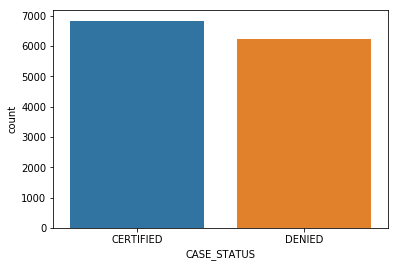

In [15]:
#Now data is balanced
sns.countplot(df_final['CASE_STATUS'])

In [17]:
#Adding new feature "diff_wage_prevailing" which is difference of privailing wage
df_final['diff_wage_prevailing'] = df_final.apply(lambda x: abs(x['PREVAILING_WAGE'] - x['WAGE_RATE_OF_PAY_FROM']), axis=1)

In [18]:
#Converting binary labels into 1 and 0
df_final.replace({'FULL_TIME_POSITION' : { 'Y' : 1, 'N' : 0}}, inplace=True)
df_final.replace({'H-1B_DEPENDENT' : { 'Y' : 1, 'N' : 0}}, inplace=True)
df_final.head()

,EMPLOYER_NAME,SOC_NAME,TOTAL_WORKERS,FULL_TIME_POSITION,PREVAILING_WAGE,WAGE_RATE_OF_PAY_FROM,H-1B_DEPENDENT,CASE_STATUS,diff_wage_prevailing
184141,THOMSON REUTERS HOLDINGS INC,COMPUTER OCCUPATION,1,1,110219.0,115000.0,0,CERTIFIED,4781.0
490923,PAYPAL INC,COMPUTER OCCUPATION,1,1,129323.0,129323.0,0,CERTIFIED,0.0
277751,HRTRONIX LLC,COMPUTER OCCUPATION,5,1,48838.0,60000.0,0,CERTIFIED,11162.0
107933,AMERICAN EXPRESS TRAVEL RELATED SERVICES COMPA...,ANALYSTS,1,1,90813.0,95000.0,0,CERTIFIED,4187.0
520727,NOBLE RESEARCH INSTITUTE LLC,COMPUTER OCCUPATION,1,1,38043.0,38043.0,0,CERTIFIED,0.0


In [19]:
#Removing Outliers from the dataset
df_outl = df_final[df_final.PREVAILING_WAGE < 150000]
df_outl = df_outl[df_outl.WAGE_RATE_OF_PAY_FROM < 150000]
sorted(df_outl['PREVAILING_WAGE'], reverse=True)
print(df_outl.head())

                                            EMPLOYER_NAME  \
184141                       THOMSON REUTERS HOLDINGS INC   
490923                                         PAYPAL INC   
277751                                       HRTRONIX LLC   
107933  AMERICAN EXPRESS TRAVEL RELATED SERVICES COMPA...   
520727                       NOBLE RESEARCH INSTITUTE LLC   

                   SOC_NAME  TOTAL_WORKERS  FULL_TIME_POSITION  \
184141  COMPUTER OCCUPATION              1                   1   
490923  COMPUTER OCCUPATION              1                   1   
277751  COMPUTER OCCUPATION              5                   1   
107933             ANALYSTS              1                   1   
520727  COMPUTER OCCUPATION              1                   1   

        PREVAILING_WAGE  WAGE_RATE_OF_PAY_FROM  H-1B_DEPENDENT CASE_STATUS  \
184141         110219.0               115000.0               0   CERTIFIED   
490923         129323.0               129323.0               0   CERTIFIED   
27

In [20]:
#Seperating "Label" from the data
X = df_outl.drop(columns = ['CASE_STATUS'])
y = df_outl['CASE_STATUS']

In [21]:
#Applying One-Hot Encoding
X_encoded = pd.get_dummies(X)
X_encoded.head()

,TOTAL_WORKERS,FULL_TIME_POSITION,PREVAILING_WAGE,WAGE_RATE_OF_PAY_FROM,H-1B_DEPENDENT,diff_wage_prevailing,EMPLOYER_NAME_1199 SEIU UNITED HEALTHCARE WORKERS EAST,EMPLOYER_NAME_14 W ADMINISTRATIVE SERVICES LLC,EMPLOYER_NAME_18|8 SOLUTIONS INC,EMPLOYER_NAME_1A DISTRIBUTION INC,...,SOC_NAME_PUBLIC RELATIONS,SOC_NAME_REAL ESTATE,SOC_NAME_RELIGIOUS WORKERS,SOC_NAME_REPORTERS AND CORRESPONDENTS,SOC_NAME_SALES AND RELATED WORKERS,SOC_NAME_SCIENTIST,SOC_NAME_SOCIAL WORKERS,SOC_NAME_SURVEYORS,SOC_NAME_TRANSPORTATION,SOC_NAME_WRITERS EDITORS AND AUTHORS
184141,1,1,110219.0,115000.0,0,4781.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
490923,1,1,129323.0,129323.0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
277751,5,1,48838.0,60000.0,0,11162.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107933,1,1,90813.0,95000.0,0,4187.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
520727,1,1,38043.0,38043.0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


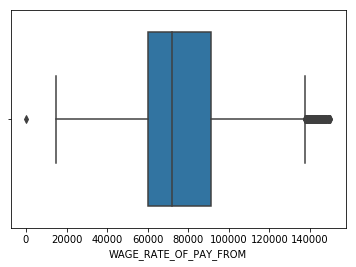

In [22]:
#Checking for Outliers
sns.boxplot(X_encoded['WAGE_RATE_OF_PAY_FROM'])

In [23]:
#Applying Min-Max normalization
x_transformed = MinMaxScaler().fit_transform(X_encoded)

#Creating Final Dataset
df_trans = pd.DataFrame(x_transformed, columns=X_encoded.columns)
print(df_trans.shape)
df_trans.tail()

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(12343, 6712)


,TOTAL_WORKERS,FULL_TIME_POSITION,PREVAILING_WAGE,WAGE_RATE_OF_PAY_FROM,H-1B_DEPENDENT,diff_wage_prevailing,EMPLOYER_NAME_1199 SEIU UNITED HEALTHCARE WORKERS EAST,EMPLOYER_NAME_14 W ADMINISTRATIVE SERVICES LLC,EMPLOYER_NAME_18|8 SOLUTIONS INC,EMPLOYER_NAME_1A DISTRIBUTION INC,...,SOC_NAME_PUBLIC RELATIONS,SOC_NAME_REAL ESTATE,SOC_NAME_RELIGIOUS WORKERS,SOC_NAME_REPORTERS AND CORRESPONDENTS,SOC_NAME_SALES AND RELATED WORKERS,SOC_NAME_SCIENTIST,SOC_NAME_SOCIAL WORKERS,SOC_NAME_SURVEYORS,SOC_NAME_TRANSPORTATION,SOC_NAME_WRITERS EDITORS AND AUTHORS
12338,0.0,1.0,0.519399,0.566709,1.0,0.055882,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12339,0.0,1.0,0.510079,0.508665,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12340,0.0,1.0,0.299680,0.298849,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12341,0.0,1.0,0.610899,0.604125,1.0,0.005824,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12342,0.0,1.0,0.509577,0.510038,0.0,0.002148,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
#Spliting the Data into 70% Training and 30% Testing
X_train, X_test, y_train, y_test = train_test_split(df_trans, y, random_state=0, test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(8640, 6712)
(3703, 6712)


### Feature Importance using RandomForests

In [26]:
#Feature importance using RandomForests (generating 100 trees)
rf_clf = RandomForestClassifier(n_estimators = 100, n_jobs=-1, random_state=42)
rf_clf.fit(X_train, y_train)

#Extracting Features and importance
features = X_train.columns
importances = rf_clf.feature_importances_

indices = np.argsort(importances)[::-1][:20]
indices200 = np.argsort(importances)[::-1][:200]

#Showing top 20 features' importance
importances[indices]

array([0.0860189 , 0.08537126, 0.071914  , 0.06139836, 0.05471018,
       0.03369251, 0.02597134, 0.015267  , 0.01427692, 0.01280908,
       0.01196142, 0.01140191, 0.00665865, 0.00632226, 0.00499345,
       0.00488887, 0.00488298, 0.0047537 , 0.00470851, 0.00440024])

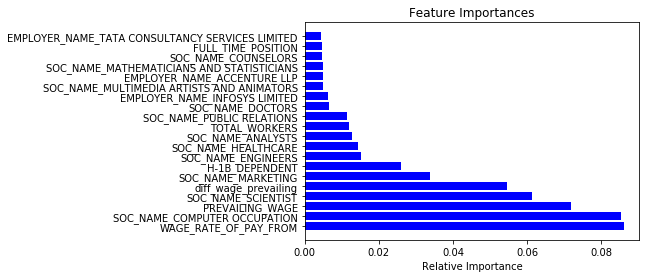

In [29]:
#Extracting Features
feat_labels = X_encoded.columns
imp_features = []
imp_features_200 = []

# top 20 features only for plotting purpose
for feature_list_index in indices:
    imp_features.append(feat_labels[feature_list_index])
    
# top 200 features for modeling purpose
for feature_list_index in indices200:
    imp_features_200.append(feat_labels[feature_list_index])

#Ploting the Feature Importance Graph of 20 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [45]:
#Generating New Training and Testing Data and Label of 200 Important Features only
X_imp_train = X_train[imp_features_200]
X_imp_test = X_test[imp_features_200]
print(X_imp_train.shape)
print(X_imp_test.shape)

(8640, 200)
(3703, 200)


### Applying models

In [31]:
#Generic Function for Plotting the Graph
def plotauc(fpr,tpr,title):
    plt.figure();
    plt.plot(fpr, tpr, color='darkorange', lw=2);
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.title(title);
    plt.show();

In [32]:
#Dictionary for converting labels into 1 and 0 for finding AUC(Area Under the Curve)
d = {'CERTIFIED': 1, 'DENIED': 0}

### 1) Random Forest

              precision    recall  f1-score   support

   CERTIFIED       0.80      0.86      0.83      1915
      DENIED       0.84      0.77      0.80      1788

   micro avg       0.82      0.82      0.82      3703
   macro avg       0.82      0.81      0.81      3703
weighted avg       0.82      0.82      0.81      3703



Accuracy :  0.8155549554415339
AUC :  0.8910989129736392


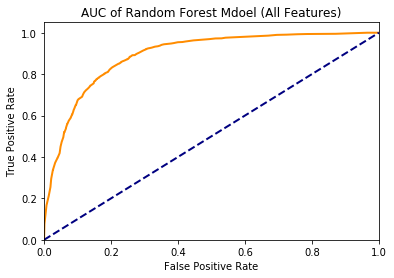

In [33]:
#Using all features
clf_rf = RandomForestClassifier(n_estimators=100)
clf_fit = clf_rf.fit(X_train, y_train) 
preds = clf_fit.predict(X_test)

#Printing Classification report and Accuracy
print(cr(y_test, preds))
print("\n")
print("Accuracy : ",accu(y_test, preds))

#Calculating auc
y_test_auc = [d[item] for item in y_test]
preds_auc=clf_fit.predict_proba(X_test) 
preds_auc = preds_auc[:,0]
fpr, tpr, thresholds = roc_curve(y_test_auc,preds_auc,pos_label=1)
print("AUC : ",auc(fpr, tpr))
plotauc(fpr,tpr,"AUC of Random Forest Mdoel (All Features)")

              precision    recall  f1-score   support

   CERTIFIED       0.80      0.83      0.81      1915
      DENIED       0.81      0.78      0.79      1788

   micro avg       0.80      0.80      0.80      3703
   macro avg       0.80      0.80      0.80      3703
weighted avg       0.80      0.80      0.80      3703



Accuracy :  0.8042128004320821
AUC :  0.8754374974445243


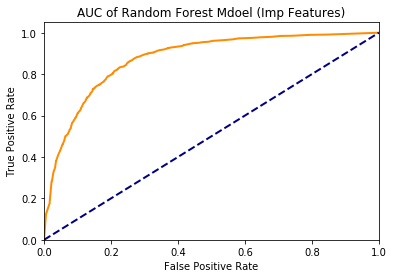

In [34]:
#Using Important Features only
clf_rf = RandomForestClassifier(n_estimators=100)
clf_fit = clf_rf.fit(X_imp_train, y_train) 
preds = clf_fit.predict(X_imp_test)

#Printing Classification report and Accuracy
print(cr(y_test, preds))
print("\n")
print("Accuracy : ",accu(y_test, preds))

#Calculating auc
y_test_auc = [d[item] for item in y_test]
preds_auc=clf_fit.predict_proba(X_imp_test)
preds_auc = preds_auc[:,0]
fpr, tpr, thresholds = roc_curve(y_test_auc,preds_auc,pos_label=1)
print("AUC : ",auc(fpr, tpr))
plotauc(fpr,tpr,"AUC of Random Forest Mdoel (Imp Features)")

### 2) Decision Tree

              precision    recall  f1-score   support

   CERTIFIED       0.79      0.85      0.82      1915
      DENIED       0.82      0.75      0.79      1788

   micro avg       0.80      0.80      0.80      3703
   macro avg       0.81      0.80      0.80      3703
weighted avg       0.80      0.80      0.80      3703

Accuracy :  0.8034026465028355
AUC :  0.8520605895993597


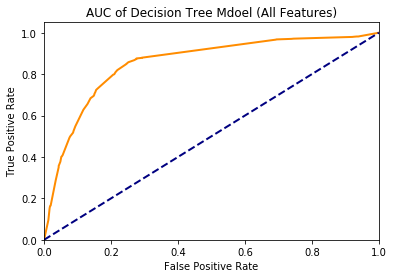

In [35]:
#Using All Features
dtc_fit = dtc(max_depth=10).fit(X_train, y_train)
preds_dtc = dtc_fit.predict(X_test)
print(cr(y_test, preds_dtc))
print("Accuracy : ",accu(y_test, preds_dtc))

#Calculating auc
y_test_auc = [d[item] for item in y_test]
preds_auc=dtc_fit.predict_proba(X_test) 
preds_auc = preds_auc[:,0]
fpr, tpr, thresholds = roc_curve(y_test_auc,preds_auc,pos_label=1)
print("AUC : ",auc(fpr, tpr))
plotauc(fpr,tpr,"AUC of Decision Tree Mdoel (All Features)")

              precision    recall  f1-score   support

   CERTIFIED       0.79      0.85      0.82      1915
      DENIED       0.82      0.76      0.79      1788

   micro avg       0.80      0.80      0.80      3703
   macro avg       0.81      0.80      0.80      3703
weighted avg       0.81      0.80      0.80      3703

Accuracy :  0.8036726978125844
AUC :  0.8527691134981686


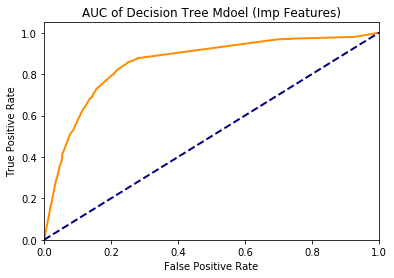

In [36]:
#Using Important Features Only
dtc_fit = dtc(max_depth=10).fit(X_imp_train, y_train)
preds_dtc = dtc_fit.predict(X_imp_test)
print(cr(y_test, preds_dtc))
print("Accuracy : ",accu(y_test, preds_dtc))

#Calculating auc
y_test_auc = [d[item] for item in y_test]
preds_auc=dtc_fit.predict_proba(X_imp_test) 
preds_auc = preds_auc[:,0]
fpr, tpr, thresholds = roc_curve(y_test_auc,preds_auc,pos_label=1)
print("AUC : ",auc(fpr, tpr))
plotauc(fpr,tpr,"AUC of Decision Tree Mdoel (Imp Features)")

### 3) KNN

              precision    recall  f1-score   support

   CERTIFIED       0.79      0.86      0.82      1915
      DENIED       0.84      0.75      0.79      1788

   micro avg       0.81      0.81      0.81      3703
   macro avg       0.81      0.81      0.81      3703
weighted avg       0.81      0.81      0.81      3703

Accuracy :  0.8071833648393195
AUC :  0.8636665381627444


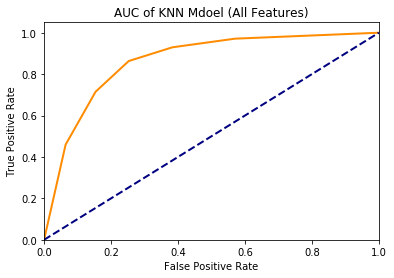

In [37]:
#Using All Features
knn_fit = knn().fit(X_train, y_train)
preds_knn = knn_fit.predict(X_test)
print(cr(y_test, preds_knn))
print("Accuracy : ",accu(y_test, preds_knn))

#Calculating auc
y_test_auc = [d[item] for item in y_test]
preds_auc=knn_fit.predict_proba(X_test) 
preds_auc = preds_auc[:,0]
fpr, tpr, thresholds = roc_curve(y_test_auc,preds_auc,pos_label=1)
print("AUC : ",auc(fpr, tpr))
plotauc(fpr,tpr,"AUC of KNN Mdoel (All Features)")

              precision    recall  f1-score   support

   CERTIFIED       0.79      0.85      0.82      1915
      DENIED       0.83      0.75      0.79      1788

   micro avg       0.80      0.80      0.80      3703
   macro avg       0.81      0.80      0.80      3703
weighted avg       0.81      0.80      0.80      3703

Accuracy :  0.8036726978125844
AUC :  0.861570025876017


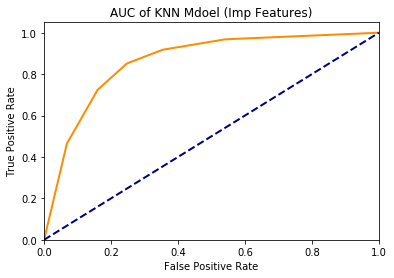

In [38]:
#Using Important Features only
knn_fit = knn().fit(X_imp_train, y_train)
preds_knn = knn_fit.predict(X_imp_test)
print(cr(y_test, preds_knn))
print("Accuracy : ",accu(y_test, preds_knn))

#Calculating auc
y_test_auc = [d[item] for item in y_test]
preds_auc=knn_fit.predict_proba(X_imp_test) 
preds_auc = preds_auc[:,0]
fpr, tpr, thresholds = roc_curve(y_test_auc,preds_auc,pos_label=1)
print("AUC : ",auc(fpr, tpr))
plotauc(fpr,tpr,"AUC of KNN Mdoel (Imp Features)")

### 4) Multinomail Naive Bayes (MNB)

              precision    recall  f1-score   support

   CERTIFIED       0.77      0.90      0.83      1915
      DENIED       0.87      0.71      0.78      1788

   micro avg       0.81      0.81      0.81      3703
   macro avg       0.82      0.80      0.80      3703
weighted avg       0.81      0.81      0.80      3703

Accuracy :  0.8055630569808263
AUC :  0.8840739832127148


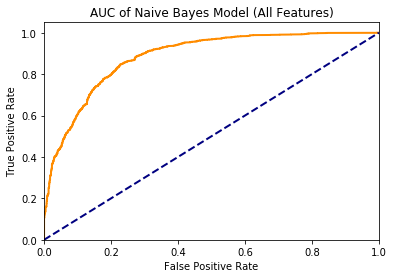

In [39]:
#Using All Features
mnb_fit = MultinomialNB().fit(X_train, y_train)
preds_mnb = mnb_fit.predict(X_test)
print(cr(y_test, preds_mnb))
print("Accuracy : ",accu(y_test, preds_mnb))

#Calculating auc
y_test_auc = [d[item] for item in y_test]
preds_auc=mnb_fit.predict_proba(X_test) 
preds_auc = preds_auc[:,0]
fpr, tpr, thresholds = roc_curve(y_test_auc,preds_auc,pos_label=1)
print("AUC : ",auc(fpr, tpr))
plotauc(fpr,tpr,"AUC of Naive Bayes Model (All Features)")

              precision    recall  f1-score   support

   CERTIFIED       0.75      0.88      0.81      1915
      DENIED       0.85      0.69      0.76      1788

   micro avg       0.79      0.79      0.79      3703
   macro avg       0.80      0.79      0.79      3703
weighted avg       0.80      0.79      0.79      3703

Accuracy :  0.7885498244666487
AUC :  0.8659470447018418


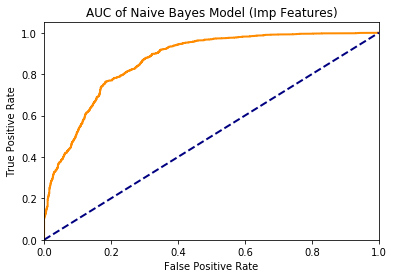

In [40]:
#Using Important Features only
mnb_fit = MultinomialNB().fit(X_imp_train, y_train)
preds_mnb = mnb_fit.predict(X_imp_test)
print(cr(y_test, preds_mnb))
print("Accuracy : ",accu(y_test, preds_mnb))

#Calculating auc
y_test_auc = [d[item] for item in y_test]
#preds_auc = [d[item] for item in preds]
preds_auc=mnb_fit.predict_proba(X_imp_test) 
preds_auc = preds_auc[:,0]
fpr, tpr, thresholds = roc_curve(y_test_auc,preds_auc,pos_label=1)
print("AUC : ",auc(fpr, tpr))
plotauc(fpr,tpr,"AUC of Naive Bayes Model (Imp Features)")

### 5) SVM

In [41]:
#Using All Features
preds_svm = svm.LinearSVC().fit(X_train, y_train).predict(X_test)
print(cr(y_test, preds_svm))
print("Accuracy : ",accu(y_test, preds_svm))

              precision    recall  f1-score   support

   CERTIFIED       0.80      0.88      0.84      1915
      DENIED       0.86      0.76      0.81      1788

   micro avg       0.82      0.82      0.82      3703
   macro avg       0.83      0.82      0.82      3703
weighted avg       0.83      0.82      0.82      3703

Accuracy :  0.8239265460437483


In [42]:
#Using Important Features Only
preds_svm = svm.LinearSVC().fit(X_imp_train, y_train).predict(X_imp_test)
print(cr(y_test, preds_svm))
print("Accuracy : ",accu(y_test, preds_svm))

              precision    recall  f1-score   support

   CERTIFIED       0.78      0.89      0.83      1915
      DENIED       0.86      0.73      0.79      1788

   micro avg       0.81      0.81      0.81      3703
   macro avg       0.82      0.81      0.81      3703
weighted avg       0.82      0.81      0.81      3703

Accuracy :  0.8139346475830408


### 6) Neural Network

C:\Users\user\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

   CERTIFIED       0.80      0.78      0.79      1915
      DENIED       0.77      0.80      0.78      1788

   micro avg       0.79      0.79      0.79      3703
   macro avg       0.79      0.79      0.79      3703
weighted avg       0.79      0.79      0.79      3703

Accuracy :  0.7877396705374021
AUC :  0.8635029877161933


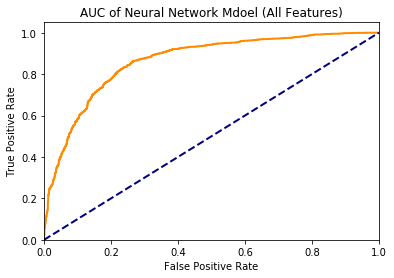

In [43]:
#Using All Features
mlp_fit = mlp(batch_size=128, learning_rate='adaptive').fit(X_train, y_train)
preds_mlp = mlp_fit.predict(X_test)
print(cr(y_test, preds_mlp))
print("Accuracy : ",accu(y_test, preds_mlp))

#Calculating auc
y_test_auc = [d[item] for item in y_test]
preds_auc=mlp_fit.predict_proba(X_test) 
preds_auc = preds_auc[:,0]
fpr, tpr, thresholds = roc_curve(y_test_auc,preds_auc,pos_label=1)
print("AUC : ",auc(fpr, tpr))
plotauc(fpr,tpr,"AUC of Neural Network Mdoel (All Features)")

C:\Users\user\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

   CERTIFIED       0.79      0.89      0.84      1915
      DENIED       0.87      0.74      0.80      1788

   micro avg       0.82      0.82      0.82      3703
   macro avg       0.83      0.82      0.82      3703
weighted avg       0.83      0.82      0.82      3703

Accuracy :  0.8204158790170132
AUC :  0.8866674260080256


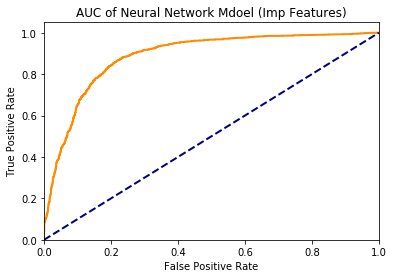

In [44]:
#Using Important Features Only
mlp_fit = mlp(learning_rate='adaptive', batch_size=128).fit(X_imp_train, y_train)
preds_mlp = mlp_fit.predict(X_imp_test)
print(cr(y_test, preds_mlp))
print("Accuracy : ",accu(y_test, preds_mlp))

#Calculating auc
y_test_auc = [d[item] for item in y_test]
preds_auc=mlp_fit.predict_proba(X_imp_test) 
preds_auc = preds_auc[:,0]
fpr, tpr, thresholds = roc_curve(y_test_auc,preds_auc,pos_label=1)
print("AUC : ",auc(fpr, tpr))
plotauc(fpr,tpr,"AUC of Neural Network Mdoel (Imp Features)")